In [1]:
from global_vars import *
from commons import *

import pickle as p
import glob 
import json
import subprocess
import getpass
import os
from nibabel.orientations import axcodes2ornt, ornt_transform, inv_ornt_aff, flip_axis
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

In [ ]:
def add_all_labels(paths):
    affine = None
    data = np.zeros((256,256,400))
    for idx, path in enumerate(paths):
        print(path)
        img = nb.load(path)
        if affine is None:
            affine = img.affine
        img_data= img.get_fdata()
        x,y,z = img.shape
        data[:x, :y, :z] += img_data
        
    empty_header = nibabel.Nifti1Header()
    all_label_img = nb.Nifti1Image(data, affine, empty_header)
    return all_label_img

def resize(img, shape=(256, 256, 400), is_label=False):
    if is_label:
        order = 0
    else:
        order = 3
    mode='constant'
    print(img.shape)
    img = resample_from_to(img, [shape, img.affine], order=order, mode=mode, cval=0)
    return img

def crop(paths, shape):
    s1, e1, s2, e2, s3, e3 = shape
    for path in paths:
        img = nb.load(path)
        img_data= img.get_fdata()
        data = img_data[s1:e1, s2:e2, s3:e3]
        img = nb.Nifti1Image(data, img.affine, img.header)
        save_path = '/'.join(path.split('/')[:-1])
        vol_id = path.split('/')[-1].split('.')[0]
        save_volume(img, f'{save_path}_cropped/{vol_id}')

def remove_black(labelmap):
    clean_labels = []
    start, end = None, None
    start_2, end_2 = None, None
    for i, frame in enumerate(labelmap):
        unique, counts = np.unique(frame, return_counts=True)
        if counts[0] / sum(counts) < .99:
            clean_labels.append(frame)
            if start is None:
                start = i
            elif start_2 is None:
                start_2 = i
            if end is not None:
                end_2 = end
            end = None
        if end is None:
            end = i
    if end is None:
        end = labelmap.shape[0]
            
    return np.array(clean_labels), start, end, start_2, end_2

In [ ]:
processed_dir = 'temp/KORA/processed'
kora_labels = glob.glob(f'{processed_dir}/label/**')
kora_volumes = glob.glob(f'{processed_dir}/volume/**')
processed_dir = 'temp/NAKO/processed'
nako_labels = glob.glob(f'{processed_dir}/label/**')
nako_volumes = glob.glob(f'{processed_dir}/volume/**')
processed_dir = 'temp/UKB/processed'
ukb_labels = glob.glob(f'{processed_dir}/label/**')
ukb_volumes = glob.glob(f'{processed_dir}/volume/**')

all_labels = kora_labels + nako_labels + ukb_labels
all_volumes = kora_volumes + nako_volumes + ukb_volumes

print(all_labels, all_volumes)

In [ ]:
for vol in all_volumes:
    vol_id = vol.split('/')[-2]
    save_path = '/'.join(vol.split('/')[:-2])
    print(vol_id, save_path)
    vol_img = nb.load(vol)
    resized_img = resize(vol_img)
    save_volume(resized_img, f'{save_path}_resized/volume/{vol_id}')

In [ ]:
for vol in all_labels:
    vol_id = vol.split('/')[-1].split('.')[0]
    save_path = '/'.join(vol.split('/')[:-2])
    print(vol_id, save_path)
    vol_img = nb.load(vol)
    resized_img = resize(vol_img, is_label=True)
    save_volume(resized_img, f'{save_path}_resized/label/{vol_id}')

In [ ]:
processed_resized_dir = 'temp/KORA/processed_resized'
kora_labels = glob.glob(f'{processed_resized_dir}/label/**')
kora_volumes = glob.glob(f'{processed_resized_dir}/volume/**')
processed_resized_dir = 'temp/NAKO/processed_resized'
nako_labels = glob.glob(f'{processed_resized_dir}/label/**')
nako_volumes = glob.glob(f'{processed_resized_dir}/volume/**')
processed_resized_dir = 'temp/UKB/processed_resized'
ukb_labels = glob.glob(f'{processed_resized_dir}/label/**')
ukb_volumes = glob.glob(f'{processed_resized_dir}/volume/**')

In [ ]:
kls = add_all_labels(kora_labels)
volume_3_view_viewer(get_volume_data(kls))
save_volume(kls, f'all_labels_merged/all_kora_labels')

kls = add_all_labels(nako_labels)
volume_3_view_viewer(get_volume_data(kls))
save_volume(kls, f'all_labels_merged/all_nako_labels')

kls = add_all_labels(ukb_labels)
volume_3_view_viewer(get_volume_data(kls))
save_volume(kls, f'all_labels_merged/all_ukb_labels')

In [ ]:
img = nb.load(f'all_labels_merged/all_kora_labels.nii.gz')
img_data = img.get_fdata()
img_d1, s1,e1, s12, e12 = remove_black(img_data)
img_data1 = np.moveaxis(img_data, 1, 0)
img_d2, s2,e2, s22, e22 = remove_black(img_data1)
img_data2 = np.moveaxis(img_data, 2, 0)
img_d3,s3,e3, s32, e32 = remove_black(img_data2)
# img_data = np.moveaxis(img_data, axis=0)

print('kora', img_d1.shape, img_d2.shape, img_d3.shape, s1,e1,s2,e2,s3,e3,'---', s12,e12,s22,e22,s32,e32)

img = nb.load(f'all_labels_merged/all_nako_labels.nii.gz')
img_data = img.get_fdata()
img_d1,s1,e1, s12, e12 = remove_black(img_data)
img_data1 = np.moveaxis(img_data, 1, 0)
img_d2,s2,e2, s22, e22 = remove_black(img_data1)
img_data2 = np.moveaxis(img_data, 2, 0)
img_d3,s3,e3, s32, e32 = remove_black(img_data2)
# img_data = np.moveaxis(img_data, axis=0)

print('nako', img_d1.shape, img_d2.shape, img_d3.shape, s1,e1,s2,e2,s3,e3,'---', s12,e12,s22,e22,s32,e32)

img = nb.load(f'all_labels_merged/all_ukb_labels.nii.gz')
img_data = img.get_fdata()
img_d1,s1,e1, s12, e12 = remove_black(img_data)
img_data1 = np.moveaxis(img_data, 1, 0)
img_d2,s2,e2, s22, e22 = remove_black(img_data1)
img_data2 = np.moveaxis(img_data, 2, 0)
img_d3,s3,e3, s32, e32 = remove_black(img_data2)
# img_data = np.moveaxis(img_data, axis=0)

print('ukb', img_d1.shape, img_d2.shape, img_d3.shape, s1,e1, s2,e2, s3,e3,'---', s12,e12,s22,e22,s32,e32)

In [ ]:
# KORA = 158,100,91   ---  49, 206, 23, 122, 84, 176  --> 40, 210, 5, 145, 80, 180 == 170, 140, 100  == 176, 144, 112/96  (Multiples of 16)
#                                                       "40, 215, 5, 175, 70, 180" == "175, 170, 110" ==  '192 176 112'== 32, 224, 2, 178, 69, 181
# NAKO = 158,104,76    --- 44, 201, 40, 143, 169, 244  --> 41, 201, 23, 143, 169, 244 == 160, 120, 75 == 160, 128, 84 =AFTER FAT TALL MATCH= 
#                                                       31, 201, 23, 143, 160, 265 == "170, 120, 105" == '192 176 112' == 20, 212, 0, 176, 157, 269
# UKB= 163, 117, 97    --- 47, 209, 42, 158, 80, 176  --> 35, 215, 25, 170, 215, 315 == 180,145, 100 == 176/192, 144/160, 112 =AFTER FAT TALL[Missing] MATCH= 
#            (Evaluated on 6 merged UKB scans. BH+NOBH) 35, 215, 25, 170, 210, 315 == "180, 145, 105" == '192 176 112' == 29, 221, 10, 186, 72, 184  (for BH Merge only)
 
# KORA sample vol size = 250, 188, 370
# NAKO sample vol size = 226,184,316
# UKB sample vol size = 246, 137, 239
# sample target shape = 256, 256,400

In [ ]:
crop(kora_volumes, [32, 224, 2, 178, 69, 181])

In [ ]:
crop(kora_labels, [32, 224, 2, 178, 69, 181])

In [ ]:
crop(nako_volumes, [20, 212, 0, 176, 157, 269])

In [ ]:
crop(nako_labels, [20, 212, 0, 176, 157, 269])

In [ ]:
crop(ukb_volumes, [29, 221, 10, 186, 72, 184])

In [ ]:
crop(ukb_labels, [29, 221, 10, 186, 72, 184])

In [2]:
processed_dir = 'temp/KORA/processed_resized'
kora_labels_c = sorted(glob.glob(f'{processed_dir}/label_cropped/**'))
kora_volumes_c = sorted(glob.glob(f'{processed_dir}/volume_cropped/**'))
processed_dir = 'temp/NAKO/processed_resized'
nako_labels_c = sorted(glob.glob(f'{processed_dir}/label_cropped/**'))
nako_volumes_c = sorted(glob.glob(f'{processed_dir}/volume_cropped/**'))
processed_dir = 'temp/UKB/processed_resized'
ukb_labels_c = sorted(glob.glob(f'{processed_dir}/label_cropped/**'))
ukb_volumes_c = sorted(glob.glob(f'{processed_dir}/volume_cropped/**'))

In [3]:
all_c = kora_labels_c+nako_labels_c+ukb_labels_c
all_c

['temp/KORA/processed_resized/label_cropped/KORA2452879.nii.gz',
 'temp/KORA/processed_resized/label_cropped/KORA2453229.nii.gz',
 'temp/KORA/processed_resized/label_cropped/KORA2453290.nii.gz',
 'temp/KORA/processed_resized/label_cropped/KORA2453363.nii.gz',
 'temp/KORA/processed_resized/label_cropped/KORA2453578.nii.gz',
 'temp/KORA/processed_resized/label_cropped/KORA2453666.nii.gz',
 'temp/KORA/processed_resized/label_cropped/KORA2456120.nii.gz',
 'temp/KORA/processed_resized/label_cropped/KORA2456289.nii.gz',
 'temp/KORA/processed_resized/label_cropped/KORA2458366.nii.gz',
 'temp/KORA/processed_resized/label_cropped/KORA2459728.nii.gz',
 'temp/KORA/processed_resized/label_cropped/KORA2459745.nii.gz',
 'temp/KORA/processed_resized/label_cropped/KORA2459908.nii.gz',
 'temp/KORA/processed_resized/label_cropped/KORA2460249.nii.gz',
 'temp/KORA/processed_resized/label_cropped/KORA2460408.nii.gz',
 'temp/KORA/processed_resized/label_cropped/KORA2460723.nii.gz',
 'temp/KORA/processed_res

KORA2452879 temp/KORA/processed_resized/volume_cropped temp/KORA/processed_resized/label_cropped temp/KORA/merged_imgs


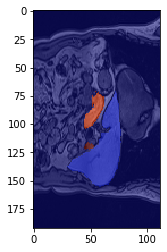

KORA2453229 temp/KORA/processed_resized/volume_cropped temp/KORA/processed_resized/label_cropped temp/KORA/merged_imgs


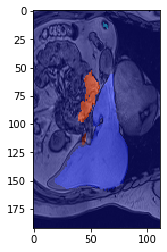

KORA2453290 temp/KORA/processed_resized/volume_cropped temp/KORA/processed_resized/label_cropped temp/KORA/merged_imgs


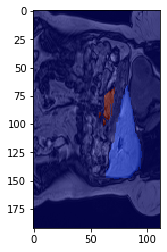

KORA2453363 temp/KORA/processed_resized/volume_cropped temp/KORA/processed_resized/label_cropped temp/KORA/merged_imgs


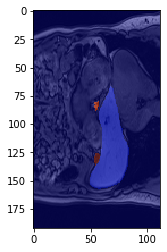

KORA2453578 temp/KORA/processed_resized/volume_cropped temp/KORA/processed_resized/label_cropped temp/KORA/merged_imgs


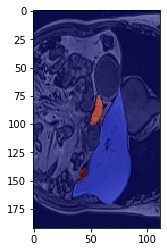

KORA2453666 temp/KORA/processed_resized/volume_cropped temp/KORA/processed_resized/label_cropped temp/KORA/merged_imgs


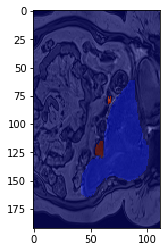

KORA2456120 temp/KORA/processed_resized/volume_cropped temp/KORA/processed_resized/label_cropped temp/KORA/merged_imgs


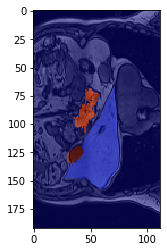

KORA2456289 temp/KORA/processed_resized/volume_cropped temp/KORA/processed_resized/label_cropped temp/KORA/merged_imgs


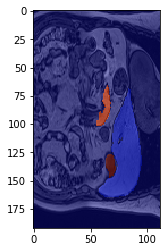

KORA2458366 temp/KORA/processed_resized/volume_cropped temp/KORA/processed_resized/label_cropped temp/KORA/merged_imgs


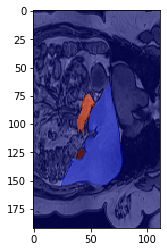

KORA2459728 temp/KORA/processed_resized/volume_cropped temp/KORA/processed_resized/label_cropped temp/KORA/merged_imgs


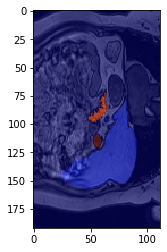

KORA2459745 temp/KORA/processed_resized/volume_cropped temp/KORA/processed_resized/label_cropped temp/KORA/merged_imgs


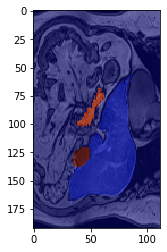

KORA2459908 temp/KORA/processed_resized/volume_cropped temp/KORA/processed_resized/label_cropped temp/KORA/merged_imgs


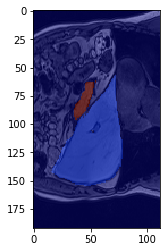

KORA2460249 temp/KORA/processed_resized/volume_cropped temp/KORA/processed_resized/label_cropped temp/KORA/merged_imgs


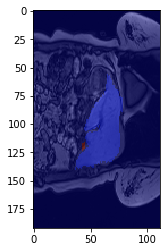

KORA2460408 temp/KORA/processed_resized/volume_cropped temp/KORA/processed_resized/label_cropped temp/KORA/merged_imgs


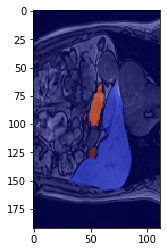

KORA2460723 temp/KORA/processed_resized/volume_cropped temp/KORA/processed_resized/label_cropped temp/KORA/merged_imgs


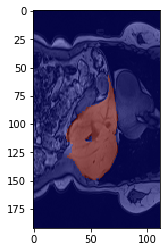

KORA2460734 temp/KORA/processed_resized/volume_cropped temp/KORA/processed_resized/label_cropped temp/KORA/merged_imgs


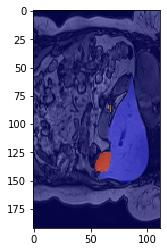

KORA2460830 temp/KORA/processed_resized/volume_cropped temp/KORA/processed_resized/label_cropped temp/KORA/merged_imgs


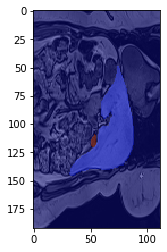

KORA2462026 temp/KORA/processed_resized/volume_cropped temp/KORA/processed_resized/label_cropped temp/KORA/merged_imgs


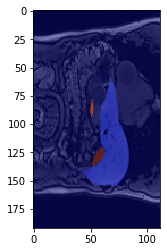

KORA2462405 temp/KORA/processed_resized/volume_cropped temp/KORA/processed_resized/label_cropped temp/KORA/merged_imgs


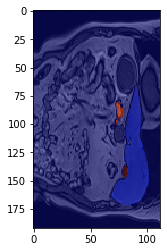

100006 temp/NAKO/processed_resized/volume_cropped temp/NAKO/processed_resized/label_cropped temp/NAKO/merged_imgs


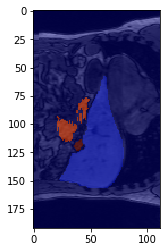

100008 temp/NAKO/processed_resized/volume_cropped temp/NAKO/processed_resized/label_cropped temp/NAKO/merged_imgs


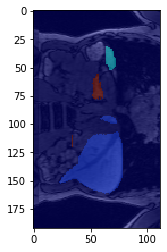

100009 temp/NAKO/processed_resized/volume_cropped temp/NAKO/processed_resized/label_cropped temp/NAKO/merged_imgs


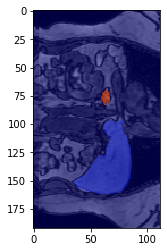

100013 temp/NAKO/processed_resized/volume_cropped temp/NAKO/processed_resized/label_cropped temp/NAKO/merged_imgs


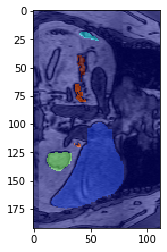

100017 temp/NAKO/processed_resized/volume_cropped temp/NAKO/processed_resized/label_cropped temp/NAKO/merged_imgs


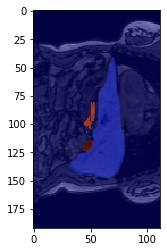

100020 temp/NAKO/processed_resized/volume_cropped temp/NAKO/processed_resized/label_cropped temp/NAKO/merged_imgs


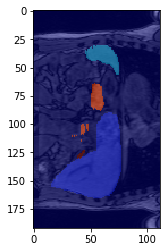

100025 temp/NAKO/processed_resized/volume_cropped temp/NAKO/processed_resized/label_cropped temp/NAKO/merged_imgs


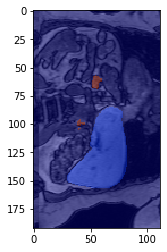

100035 temp/NAKO/processed_resized/volume_cropped temp/NAKO/processed_resized/label_cropped temp/NAKO/merged_imgs


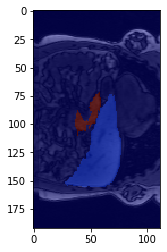

100083 temp/NAKO/processed_resized/volume_cropped temp/NAKO/processed_resized/label_cropped temp/NAKO/merged_imgs


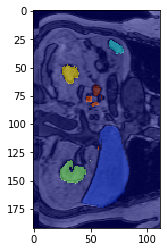

100085 temp/NAKO/processed_resized/volume_cropped temp/NAKO/processed_resized/label_cropped temp/NAKO/merged_imgs


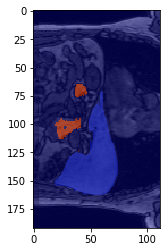

100094 temp/NAKO/processed_resized/volume_cropped temp/NAKO/processed_resized/label_cropped temp/NAKO/merged_imgs


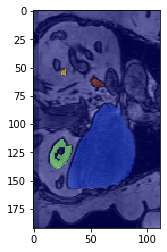

100097 temp/NAKO/processed_resized/volume_cropped temp/NAKO/processed_resized/label_cropped temp/NAKO/merged_imgs


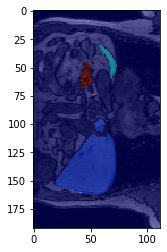

100112 temp/NAKO/processed_resized/volume_cropped temp/NAKO/processed_resized/label_cropped temp/NAKO/merged_imgs


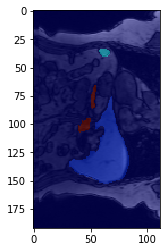

100116 temp/NAKO/processed_resized/volume_cropped temp/NAKO/processed_resized/label_cropped temp/NAKO/merged_imgs


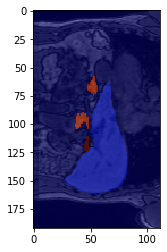

100129 temp/NAKO/processed_resized/volume_cropped temp/NAKO/processed_resized/label_cropped temp/NAKO/merged_imgs


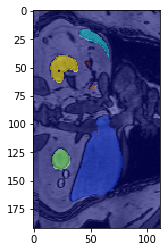

100142 temp/NAKO/processed_resized/volume_cropped temp/NAKO/processed_resized/label_cropped temp/NAKO/merged_imgs


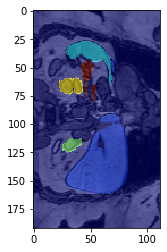

100161 temp/NAKO/processed_resized/volume_cropped temp/NAKO/processed_resized/label_cropped temp/NAKO/merged_imgs


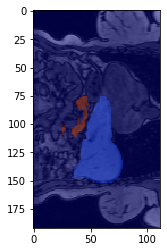

100181 temp/NAKO/processed_resized/volume_cropped temp/NAKO/processed_resized/label_cropped temp/NAKO/merged_imgs


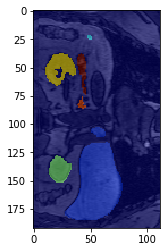

100183 temp/NAKO/processed_resized/volume_cropped temp/NAKO/processed_resized/label_cropped temp/NAKO/merged_imgs


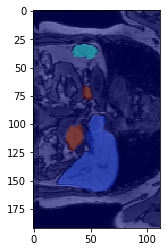

1002359_20201_2_0 temp/UKB/processed_resized/volume_cropped temp/UKB/processed_resized/label_cropped temp/UKB/merged_imgs


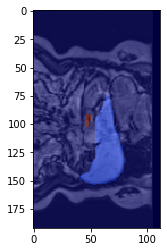

1003082_20201_2_0 temp/UKB/processed_resized/volume_cropped temp/UKB/processed_resized/label_cropped temp/UKB/merged_imgs


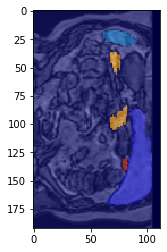

1005379_20201_2_0 temp/UKB/processed_resized/volume_cropped temp/UKB/processed_resized/label_cropped temp/UKB/merged_imgs


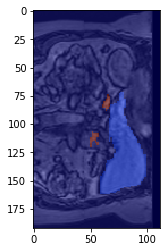

1013250_20201_2_0 temp/UKB/processed_resized/volume_cropped temp/UKB/processed_resized/label_cropped temp/UKB/merged_imgs


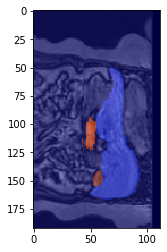

1013391_20201_2_0 temp/UKB/processed_resized/volume_cropped temp/UKB/processed_resized/label_cropped temp/UKB/merged_imgs


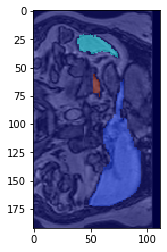

1019631_20201_2_0 temp/UKB/processed_resized/volume_cropped temp/UKB/processed_resized/label_cropped temp/UKB/merged_imgs


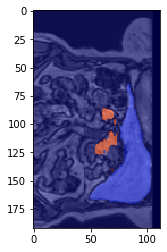

1026125_20201_2_0 temp/UKB/processed_resized/volume_cropped temp/UKB/processed_resized/label_cropped temp/UKB/merged_imgs


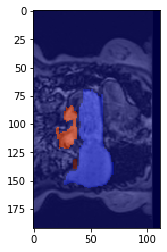

1036900_20201_2_0 temp/UKB/processed_resized/volume_cropped temp/UKB/processed_resized/label_cropped temp/UKB/merged_imgs


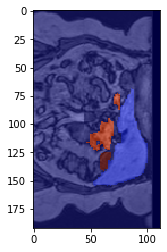

1108214_20201_2_0 temp/UKB/processed_resized/volume_cropped temp/UKB/processed_resized/label_cropped temp/UKB/merged_imgs


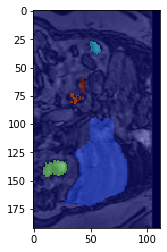

1138634_20201_2_0 temp/UKB/processed_resized/volume_cropped temp/UKB/processed_resized/label_cropped temp/UKB/merged_imgs


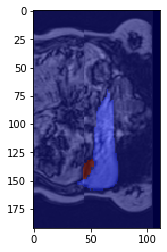

1584559_20201_2_0 temp/UKB/processed_resized/volume_cropped temp/UKB/processed_resized/label_cropped temp/UKB/merged_imgs


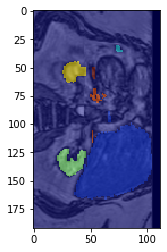

1883132_20201_2_0 temp/UKB/processed_resized/volume_cropped temp/UKB/processed_resized/label_cropped temp/UKB/merged_imgs


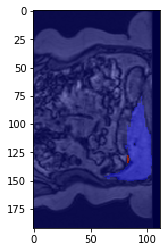

1942395_20201_2_0 temp/UKB/processed_resized/volume_cropped temp/UKB/processed_resized/label_cropped temp/UKB/merged_imgs


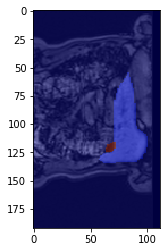

3387088_20201_2_0 temp/UKB/processed_resized/volume_cropped temp/UKB/processed_resized/label_cropped temp/UKB/merged_imgs


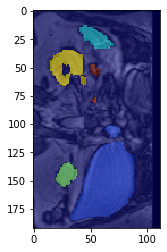

4154467_20201_2_0 temp/UKB/processed_resized/volume_cropped temp/UKB/processed_resized/label_cropped temp/UKB/merged_imgs


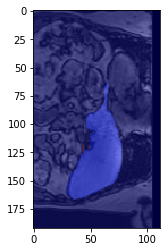

4627690_20201_2_0 temp/UKB/processed_resized/volume_cropped temp/UKB/processed_resized/label_cropped temp/UKB/merged_imgs


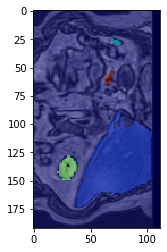

5331775_20201_2_0 temp/UKB/processed_resized/volume_cropped temp/UKB/processed_resized/label_cropped temp/UKB/merged_imgs


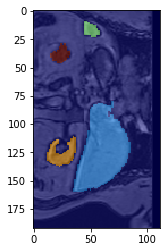

5371767_20201_2_0 temp/UKB/processed_resized/volume_cropped temp/UKB/processed_resized/label_cropped temp/UKB/merged_imgs


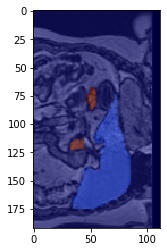

5397022_20201_2_0 temp/UKB/processed_resized/volume_cropped temp/UKB/processed_resized/label_cropped temp/UKB/merged_imgs


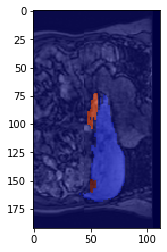

5764643_20201_2_0 temp/UKB/processed_resized/volume_cropped temp/UKB/processed_resized/label_cropped temp/UKB/merged_imgs


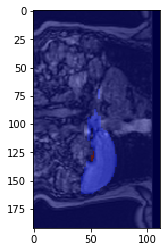

5833278_20201_2_0 temp/UKB/processed_resized/volume_cropped temp/UKB/processed_resized/label_cropped temp/UKB/merged_imgs


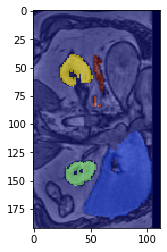

5934622_20201_2_0 temp/UKB/processed_resized/volume_cropped temp/UKB/processed_resized/label_cropped temp/UKB/merged_imgs


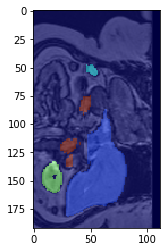

6025746_20201_2_0 temp/UKB/processed_resized/volume_cropped temp/UKB/processed_resized/label_cropped temp/UKB/merged_imgs


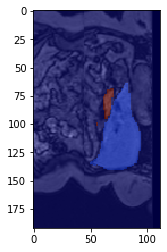

In [4]:
for p in all_c:
    volid = p.split('/')[-1].split('.')[0]
    vol_root= '/'.join(p.split('/')[:-2])+'/volume_cropped'
    label_root=  '/'.join(p.split('/')[:-2])+'/label_cropped'
    img_save_path= '/'.join(p.split('/')[:-3])+'/merged_imgs'
    print(volid, vol_root, label_root, img_save_path)
    visualize_and_save(volid, vol_root, label_root, img_save_path)